In [268]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from S00_utils import loadPickle, plot_res, store_results

In [269]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [270]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

dfX = df[colsX]
dfY = df[colsY]

In [271]:
imgData = loadPickle("output/S22__2025-04-21-062139.pickle")

In [272]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)


[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [273]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
img_train = imgData[idxTrain, :, :, :]
img_test = imgData[idxTest, :, :, :]


In [274]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [275]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)

In [276]:
from torchvision import transforms
import torch.nn.functional as F

img_train_torch = torch.from_numpy(img_train).float()
img_test_torch = torch.from_numpy(img_test).float()

# Normalize
mean = torch.mean(img_train_torch, dim=(0, 2, 3))
std = torch.std(img_train_torch, dim=(0, 2, 3))
print(mean, std)

normalize = transforms.Normalize(mean=[mean], std=[std])
img_train_torch_norm = torch.stack([normalize(img) for img in img_train_torch])
img_test_torch_norm = torch.stack([normalize(img) for img in img_test_torch])
print(img_train_torch_norm.shape)
print(img_test_torch_norm.shape)

# Resize
new_size = (32, 32)
img_train_torch_norm_resize = F.interpolate(
    img_train_torch_norm, size=new_size, mode="bilinear", align_corners=False
)
img_test_torch_norm_resize = F.interpolate(
    img_test_torch_norm, size=new_size, mode="bilinear", align_corners=False
)
print(img_train_torch_norm_resize.shape)
print(img_test_torch_norm_resize.shape)

tensor([0.1284]) tensor([1.3103])
torch.Size([70, 1, 64, 200])
torch.Size([30, 1, 64, 200])
torch.Size([70, 1, 32, 32])
torch.Size([30, 1, 32, 32])


In [277]:
class MyModel(nn.Module):
    def __init__(self, numChannels, num_out_features):
        # call the parent constructor
        super(MyModel, self).__init__()
        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = nn.Conv2d(
            in_channels=numChannels, out_channels=20, kernel_size=(5, 5)
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.relu3 = nn.ReLU()
        # initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=500, out_features=num_out_features)

In [278]:
class CNNRegression(nn.Module):
    def __init__(self):
        super(CNNRegression, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Downsampling

        # Adaptive pooling to handle variable image sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 2)  # Output is a single continuous value

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (N, 16, H/2, W/2)
        x = self.pool(F.relu(self.conv2(x)))  # -> (N, 32, H/4, W/4)
        x = self.adaptive_pool(x)  # -> (N, 32, 4, 4)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for regression
        return x

In [279]:
class CNNWithFeatures(nn.Module):
    def __init__(self, num_features, output_dim=3):
        super(CNNWithFeatures, self).__init__()

        # CNN branch for image input
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected for CNN features
        self.cnn_fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 64),
            nn.ReLU()
        )

        # Fully connected for extra tabular features
        self.feature_fc = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU()
        )

        # Combined head
        self.combined_fc = nn.Sequential(
            nn.Linear(64 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)  # regression: output_dim=1
        )

    def forward(self, image, features):
        # CNN image pipeline
        x = self.pool(F.relu(self.conv1(image)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.cnn_fc(x)

        # Tabular feature pipeline
        f = self.feature_fc(features)

        # Combine and predict
        combined = torch.cat((x, f), dim=1)
        out = self.combined_fc(combined)
        return out

In [280]:
model = CNNWithFeatures(num_features=dfX.shape[1])
test_output = model(img_train_torch_norm_resize, X_train_std)
print(test_output.shape)

torch.Size([70, 3])


In [281]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [282]:
Y_train_std.shape

torch.Size([70, 3])

MSE: 0.00
RMSE: 0.04


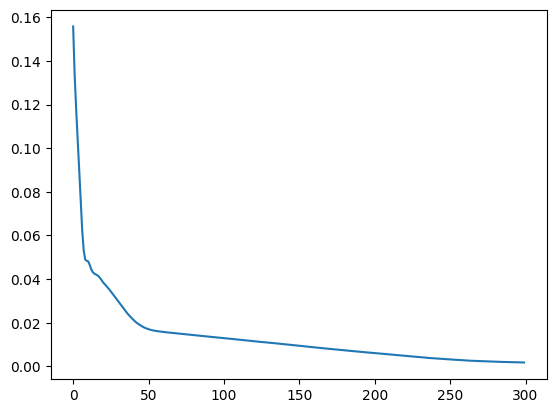

In [283]:
n_epochs = 300  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            F_batch = img_train_torch_norm_resize[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred = model(F_batch, X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(img_test_torch_norm_resize, X_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [284]:
Y_train_pred = model(img_train_torch_norm_resize, X_train_std)
Y_test_pred = model(img_test_torch_norm_resize, X_test_std)

In [285]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.001264,0.002258,0.971801,0.957871
1,0.001496,0.002028,0.961055,0.934410
2,0.000497,0.001054,0.991543,0.979898


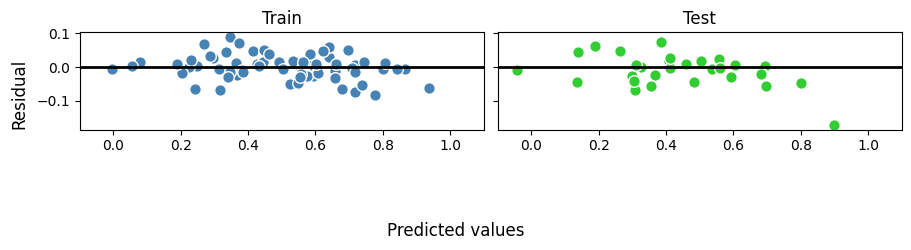

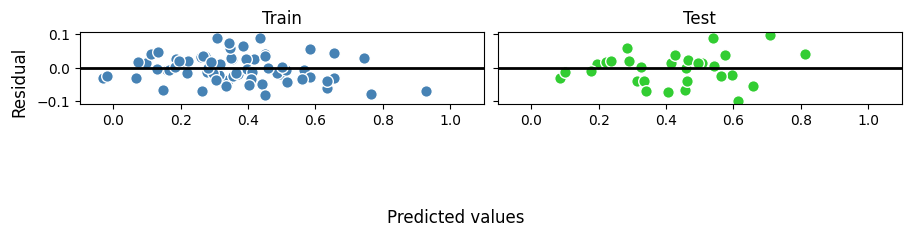

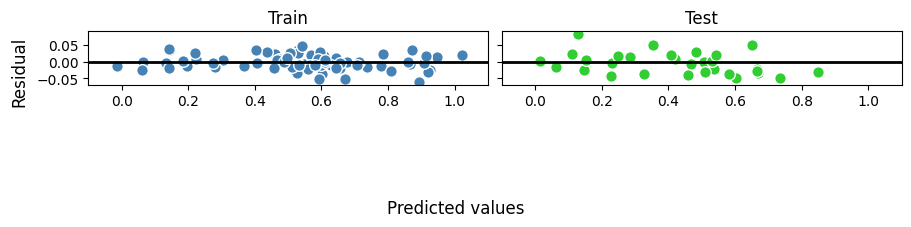

In [286]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes